In [ ]:
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split

def split_dataset(source_dir, target_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1."

    classes = ['cats', 'dogs', 'snakes']

    for cls in classes:

        for split in ['train', 'val', 'test']:
            split_dir = Path(target_dir) / split / cls
            split_dir.mkdir(parents=True, exist_ok=True)

        images = [img for img in os.listdir(os.path.join(source_dir, cls)) if img.lower().endswith(('png', 'jpg', 'jpeg'))]


        train_imgs, temp_imgs = train_test_split(images, train_size=train_ratio, random_state=42)


        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_ratio/(test_ratio + val_ratio), random_state=42)


        for image_set, subset in zip([train_imgs, val_imgs, test_imgs], ['train', 'val', 'test']):
            for image_name in image_set:
                src = os.path.join(source_dir, cls, image_name)
                dst = os.path.join(target_dir, subset, cls, image_name)
                shutil.copy2(src, dst)

    print("Splitting complete.")


source_directory = "/content/drive/MyDrive/XAI/Animals"
target_directory = "/content/drive/MyDrive/XAI/Animals/dataset"

split_dataset(source_directory, target_directory)


In [ ]:
import os

# displaying the total number of images in train test validation

def count_images_in_split(split_dir):
    total_images = 0
    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len([
                img for img in os.listdir(class_path)
                if img.lower().endswith(('png', 'jpg', 'jpeg'))
            ])
            print(f"Class '{class_name}' has {num_images} images in '{os.path.basename(split_dir)}' set.")
            total_images += num_images
    print(f"Total images in '{os.path.basename(split_dir)}' set: {total_images}\n")


dataset_root = "/content/drive/MyDrive/XAI/Animals/dataset"

for split in ['train', 'val', 'test']:
    split_dir = os.path.join(dataset_root, split)
    count_images_in_split(split_dir)


In [1]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# image transformation for equal length for feeding into neural network
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# train test val data loading for model training
train_dataset = datasets.ImageFolder(root='/Users/abhishekdas/Documents/new_project/ExplainableAI/dataset/train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='/Users/abhishekdas/Documents/new_project/ExplainableAI/dataset/val', transform=val_test_transform)
test_dataset = datasets.ImageFolder(root='/Users/abhishekdas/Documents/new_project/ExplainableAI/dataset/test', transform=val_test_transform)

# DataLoaders with batch size 32 and train shuffle = True for model training
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


['cats', 'dogs', 'snakes']


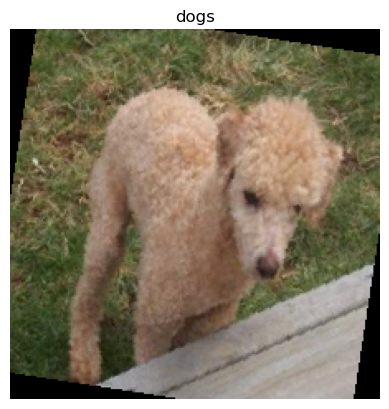

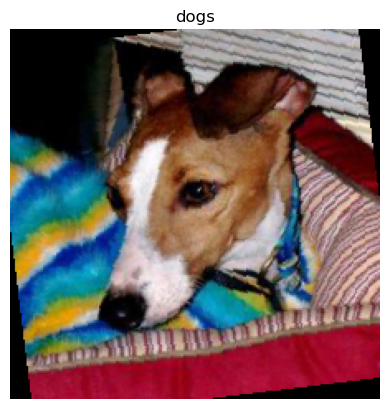

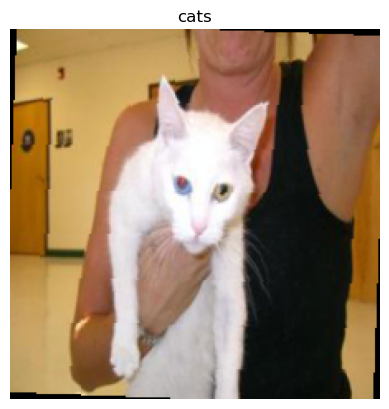

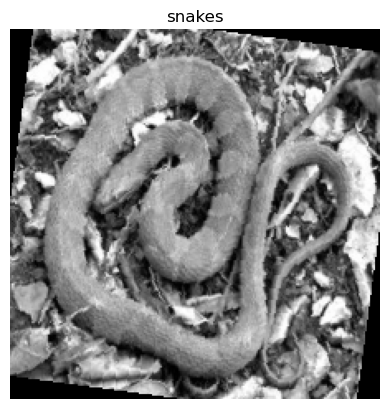

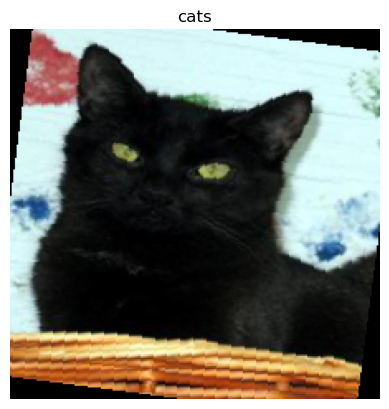

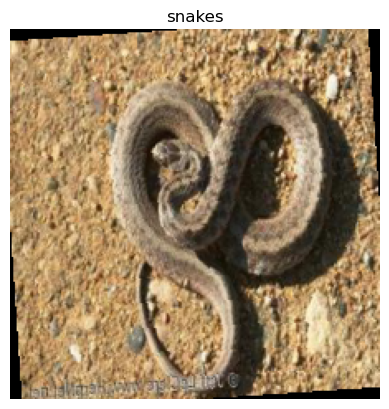

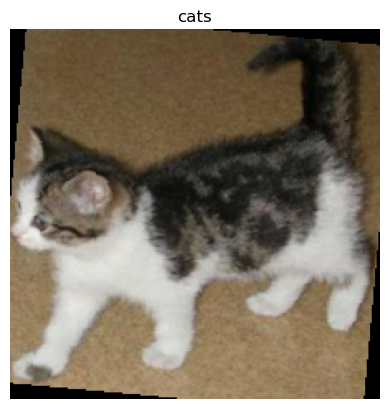

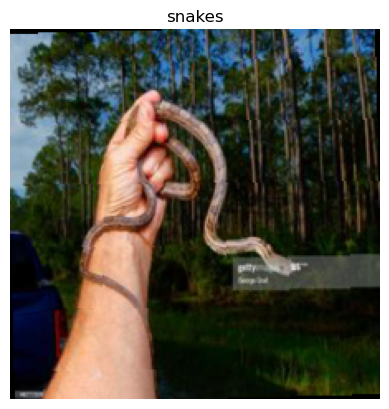

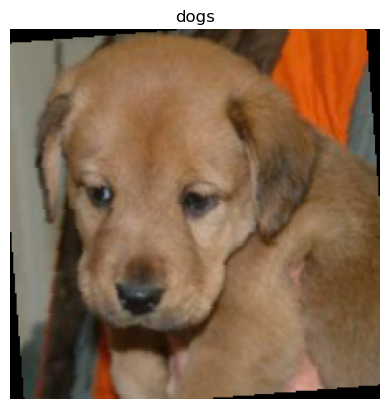

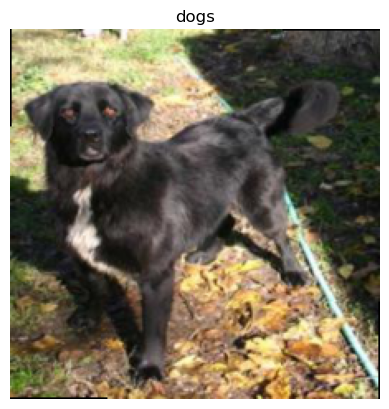

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# imshow will display the images after unnormalising
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# class name as per folder dataset
class_names = train_dataset.classes
print(class_names)
dataiter = iter(train_loader)
images, labels = next(dataiter)

# sample displaying of images
for i in range(10):
    imshow(images[i], title=class_names[labels[i]])


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TrialCNN(nn.Module):
    def __init__(self):
        super(TrialCNN, self).__init__()

        # 1st Block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        # 2nd lock
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Block 3
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        # neural networks
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 3)
        #number of class for this problem statement is 3 i.e. dog cat snake
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool3(x)

        x = x.view(x.size(0), -1)  # Flatten

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TrialCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
# training pipeline
num_epochs = 100
best_val_acc = 0.0

for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    running_corrects = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)


    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = val_running_corrects.double() / len(val_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

    # model saving as per best validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/XAI/best_trialcnn_model.pth')
        print(f"Best model saved at epoch {epoch+1} with val acc: {val_acc:.4f}")



In [ ]:
## Chckpoint saving for further experiemntaion
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, '/content/drive/MyDrive/XAI/full_checkpoint.pth')

print("Full checkpoint saved after training!")



In [5]:
import torch

#  model instance
model = TrialCNN()

# cpu model loading
model.load_state_dict(torch.load('/Users/abhishekdas/Documents/new_project/ExplainableAI/best_trialcnn_model.pth', map_location=torch.device('cpu')))

# Now move the model to CPU
model.to(torch.device('cpu'))

model.eval()


TrialCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [6]:
# Testing the model with test dataset of 15% unseen data
model.eval()
test_corrects = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels.data)

test_acc = test_corrects.double() / len(test_loader.dataset)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.7644


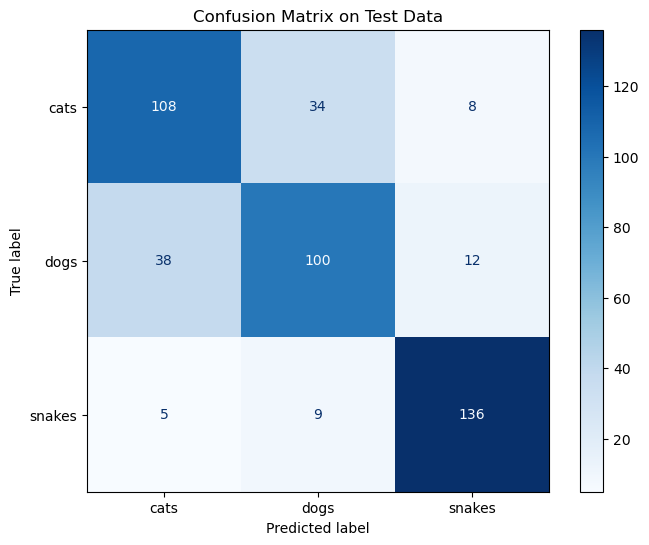

In [7]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



# confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.classes

# confusion matrix plotting
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix on Test Data')
plt.show()


In [8]:
# accuracy metrics of the model
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=class_names))


              precision    recall  f1-score   support

        cats       0.72      0.72      0.72       150
        dogs       0.70      0.67      0.68       150
      snakes       0.87      0.91      0.89       150

    accuracy                           0.76       450
   macro avg       0.76      0.76      0.76       450
weighted avg       0.76      0.76      0.76       450



In [9]:
import torch

device = torch.device('cpu')

model = TrialCNN().to(device)

# model loading
model.load_state_dict(torch.load(
    '/Users/abhishekdas/Documents/new_project/ExplainableAI/best_trialcnn_model.pth', 
    map_location=device   
))

model.eval()


TrialCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [10]:
from torchvision import transforms
from PIL import Image

#image transformation before test as model
#training
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


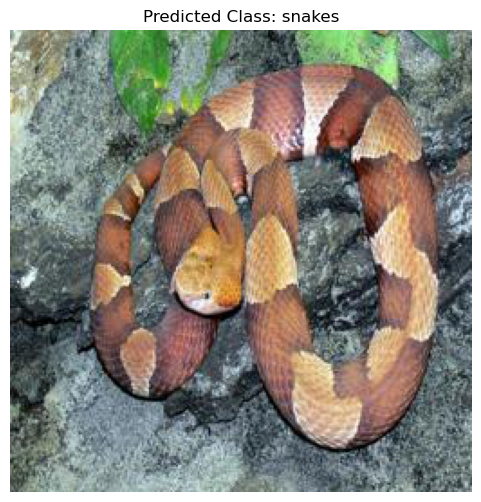

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# input image
img_path = '/Users/abhishekdas/Documents/new_project/ExplainableAI/dataset/test/snakes/2_0968.jpg'
img = Image.open(img_path).convert('RGB')

# image transformation
img_transformed = test_transform(img)
img_transformed = img_transformed.unsqueeze(0)
img_transformed = img_transformed.to(device)

# Prediction
outputs = model(img_transformed)
_, predicted = torch.max(outputs, 1)

class_names = train_dataset.classes

# displaying pic with prediction
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title(f"Predicted Class: {class_names[predicted.item()]}")
plt.axis('off')
plt.show()


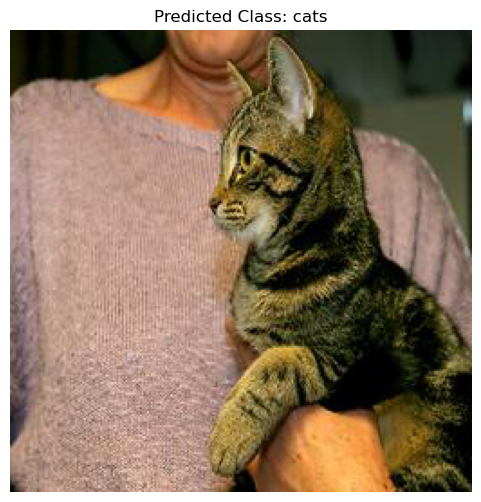

In [12]:
# input image 02
img_path = '/Users/abhishekdas/Documents/new_project/ExplainableAI/dataset/train/cats/0_0001.jpg'
img = Image.open(img_path).convert('RGB')

# image transformation as per model requirement
img_transformed = test_transform(img)
img_transformed = img_transformed.unsqueeze(0)  # Add batch dimension
img_transformed = img_transformed.to(device)

# prediction
outputs = model(img_transformed)
_, predicted = torch.max(outputs, 1)

class_names = train_dataset.classes

# displaying pic with prediction
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title(f"Predicted Class: {class_names[predicted.item()]}")
plt.axis('off')
plt.show()


In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from captum.attr import LayerGradCam, LayerAttribution

def gradcam_images(model, image_path, target_layer, class_names, transform, device, colormap='inferno', gamma=0.5, alpha_heatmap=0.6):


    # loading and preprocess the input image
    img = Image.open(image_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()
    outputs = model(input_tensor)
    pred_class = outputs.argmax(dim=1).item()

    # gradcam initialisation
    gradcam = LayerGradCam(model, target_layer)
    attributions = gradcam.attribute(input_tensor, target=pred_class)
    upsampled_attr = LayerAttribution.interpolate(attributions, input_tensor.shape[2:])
    heatmap = upsampled_attr.squeeze().cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (heatmap.max() + 1e-8)
    heatmap = heatmap ** gamma
    img_np = np.array(img) / 255.0
    heatmap_resized = np.uint8(255 * heatmap)
    heatmap_resized = Image.fromarray(heatmap_resized).resize((img_np.shape[1], img_np.shape[0]))
    heatmap_resized = np.array(heatmap_resized)

    #  colormap
    if colormap == 'inferno':
        cmap = plt.cm.inferno
    elif colormap == 'magma':
        cmap = plt.cm.magma
    else:
        cmap = plt.cm.jet

    heatmap_colored = cmap(heatmap_resized)[:, :, :3]
    superimposed_img = heatmap_colored * alpha_heatmap + img_np * (1 - alpha_heatmap)
    superimposed_img = np.clip(superimposed_img, 0, 1)

    # displaying both images side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(img_np)
    axes[0].set_title(f"Original Image\nPredicted: {class_names[pred_class]}")
    axes[0].axis('off')

    axes[1].imshow(superimposed_img)
    axes[1].set_title(f"GradCAM Heatmap\nPrediction: {class_names[pred_class]}")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


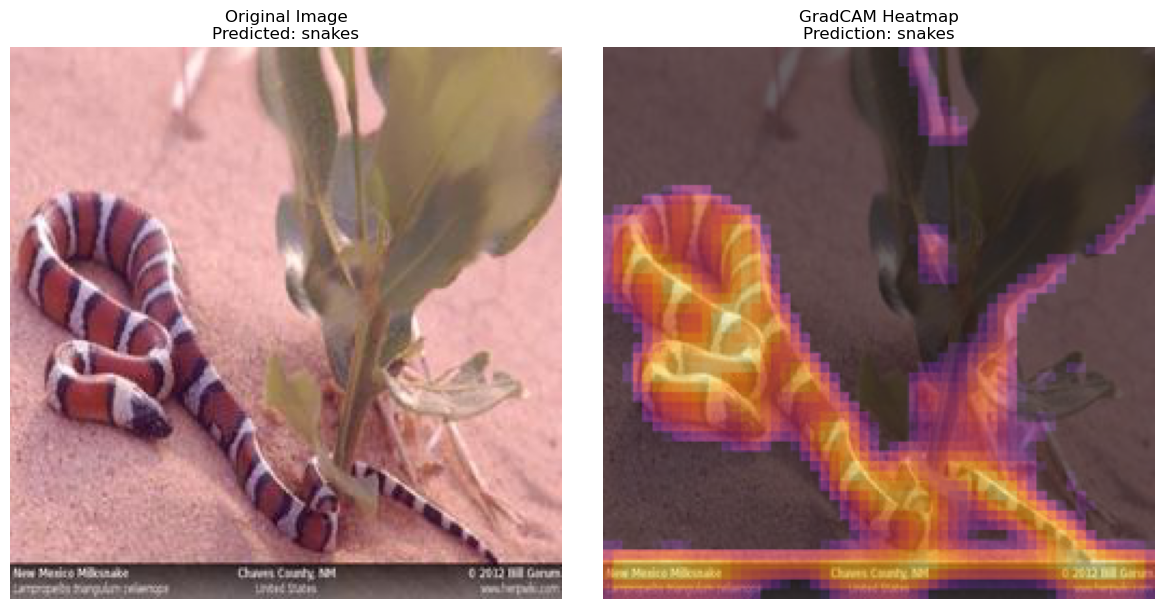

In [14]:
## test image 1 for checking

gradcam_images(
    model=model,
    image_path='/Users/abhishekdas/Documents/new_project/ExplainableAI/dataset/val/snakes/2_0010.jpg',
    target_layer=model.conv6,
    class_names=['cats', 'dogs', 'snakes'],
    transform=test_transform,
    device=device,
    colormap='inferno',
    gamma=0.5,
    alpha_heatmap=0.6
)


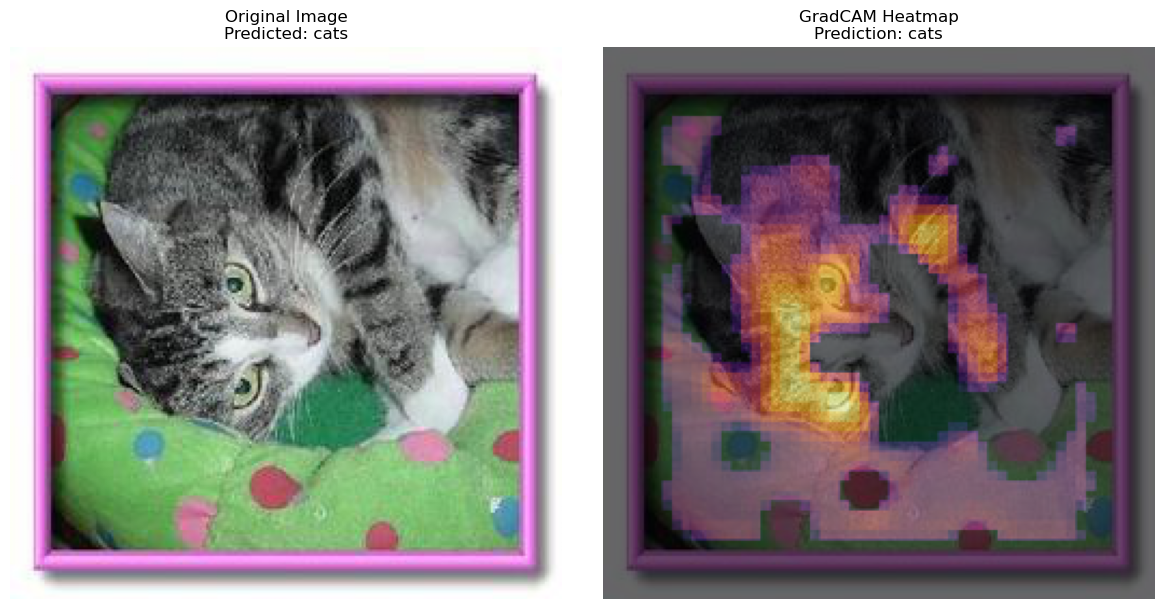

In [15]:
## test image 2 for checking

gradcam_images(
    model=model,
    image_path='/Users/abhishekdas/Documents/new_project/ExplainableAI/dataset/train/cats/0_0005.jpg',
    target_layer=model.conv6,
    class_names=['cats', 'dogs', 'snakes'],
    transform=test_transform,
    device=device,
    colormap='inferno',
    gamma=0.5,
    alpha_heatmap=0.6
)


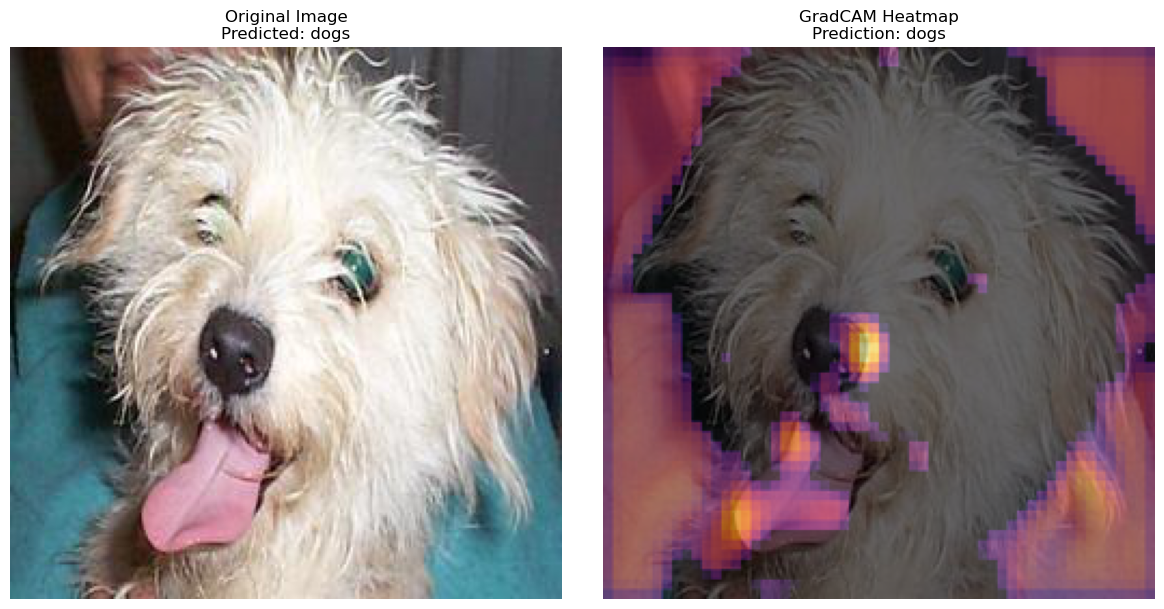

In [16]:
## test image 3 for checking

gradcam_images(
    model=model,
    image_path='/Users/abhishekdas/Documents/new_project/ExplainableAI/dataset/val/dogs/1_0065.jpg',
    target_layer=model.conv6,
    class_names=['cats', 'dogs', 'snakes'],
    transform=test_transform,
    device=device,
    colormap='inferno',
    gamma=0.5,
    alpha_heatmap=0.6
)


In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image

def lime_XAI(model, image_path, class_names, transform, device, num_samples=1000, num_features=5):

    model.eval()

    # prediction function
    def batch_predict(images):
        images = torch.stack([transform(Image.fromarray(img)).to(device) for img in images], dim=0)
        outputs = model(images)
        return outputs.softmax(dim=1).detach().cpu().numpy()

    # load and preprocess for the testing image
    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img)


    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img_np,
        batch_predict,
        top_labels=1,
        hide_color=0,
        num_samples=num_samples
    )

    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=True,
        hide_rest=False,
        num_features=num_features,
        min_weight=0.0
    )

    # Plot the image with specific region
    plt.figure(figsize=(8,8))
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f'LIME: Predicted - {class_names[explanation.top_labels[0]]}')
    plt.axis('off')
    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

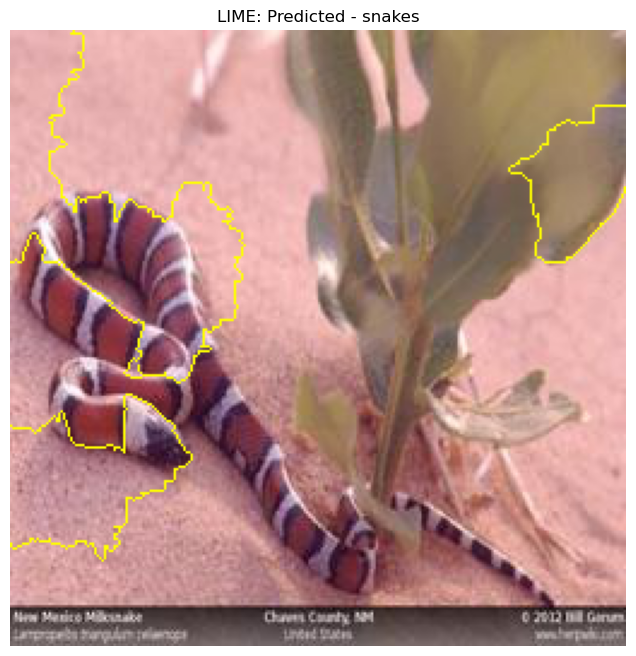

In [18]:
## lime test image 1 for showing region
lime_XAI(
    model=model,
    image_path='/Users/abhishekdas/Documents/new_project/ExplainableAI/dataset/val/snakes/2_0010.jpg',
    class_names=['cats', 'dogs', 'snakes'],
    transform=test_transform,
    device=device,
    num_samples=1000,
    num_features=5
)


  0%|          | 0/1000 [00:00<?, ?it/s]

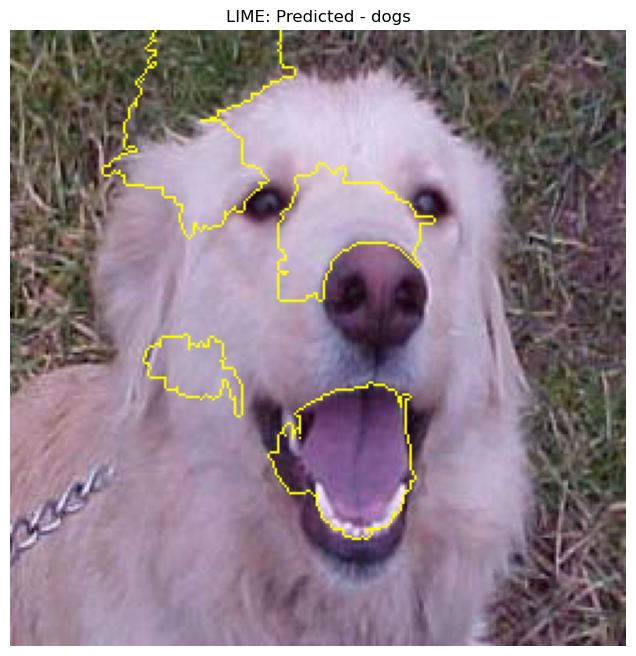

In [19]:
## lime test image 2 for showing region
lime_XAI(
    model=model,
    image_path='/Users/abhishekdas/Documents/new_project/ExplainableAI/dataset/val/dogs/1_0047.jpg',
    class_names=['cats', 'dogs', 'snakes'],
    transform=test_transform,
    device=device,
    num_samples=1000,
    num_features=5
)
